<a href="https://colab.research.google.com/github/g-r-a-e-m-e/essential-math-for-data-science/blob/main/chapter_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06
## Logistic Regression and Classification

### Performing a Logistic Regression

#### Logistic Function

$y = {\displaystyle \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x)}}}$

In [1]:
# Example 6-1. The logistic function
import math

# Define function to predict probability
def predict_probability(x, b0, b1):
  p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
  return p

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


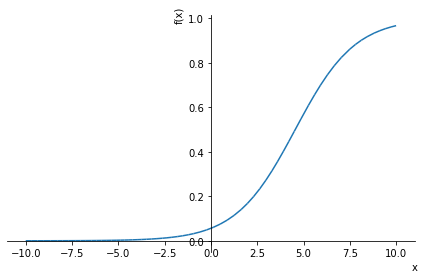

In [2]:
# Example 6-2. Using SymPy to plot a logistic function
from sympy import *
b0, b1, x = symbols('b0 b1 x')

p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))

p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)
print(p)

plot(p)

Alternative logistic function

$p = {\displaystyle \frac{e^{\beta_0 + \beta_1 x}}{1.0 + e^{\beta_0 + \beta_1 x}}}$

Extending logistic function to more variables

$p = {\displaystyle \frac{1.0}{e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n)}}}$

#### Fitting the Logistic Curve


##### Using SciPy

[0.69267212]
[-3.17576395]


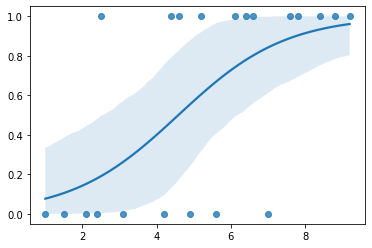

In [3]:
# Example 6-3. Using a plain logistic regression in SciPy
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Load data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',')

# Extract input variables
X = df.values[:, :-1]

# Extract output column
y = df.values[:, -1]

# Perform logistic regression
model = LogisticRegression(penalty = 'none')

# Fit model
model.fit(X, y)

# Print beta_1
print(model.coef_.flatten())

# Print beta_0
print(model.intercept_.flatten())

# Plot results
sns.regplot(x = X, y = y, data = df, logistic = True)

##### Using Maximum Likelihood and Gradient Descent

In [4]:
# Example 6-4. Calculating the joint likelihood for a given logistic regression
import math
import pandas as pd

# Import data
patient_data = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',').itertuples()

# Set beta coefficients
b0 = -3.17576395
b1 = 0.69267212

# Define logistic function
def logistic_function(x):
  p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
  return p

# Calculate joint likelihood
joint_likelihood = 1.0

for p in patient_data:
  if p.y == 1.0:
    joint_likelihood *= logistic_function(p.x)
  elif p.y == 0.0:
    joint_likelihood *= (1.0 - logistic_function(p.x))

# Print results
print(joint_likelihood)

4.7911180221699105e-05


$\text{joint likelihood} = {\displaystyle \prod_{i = 1}^n 
\left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{y_i} 
\times 
\left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{1.0 - y_i}}$

In [5]:
# Example 6-5. Compressing the joint likelihood function without an if
for p in patient_data:
  joint_likelihood *= logistic_function(p.x) ** p.y *\
                      (1.0 - logistic_function(p.x) ** (1.0 - p.y))

print(joint_likelihood)

4.7911180221699105e-05


In [7]:
# Example 6-6. Using logarithmic addition
# Calculate the joint likelihood
joint_likelihood = 0.0

for p in patient_data:
  joint_likelihood += math.log(logistic_function(p.x) ** p.y * \
                              (1.0 - logistic_function(p.x)) ** (1.0 - p.y))

joint_likelihood = math.exp(joint_likelihood)

print(joint_likelihood)

1.0


$\text{joint likelihood} = 
{\displaystyle 
\sum_{i = 1}^n \log 
\left( 
  \left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{y_i} 
  \times 
  \left( \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x_i)}} \right)^{1.0 - y_i}
\right)}
$

In [9]:
# Example 6-7. Expressing a joint likelihood for a logistic regression in SymPy
#joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b + m * x(i))))) ** y(i) \
#                           (1.0 - (1.0 / (1.0 + exp(-(b + m * x(i)))))) ** (1 - y(i))), (i, 0, n))

In [11]:
# Example 6-8. Using gradient descent on logistic regression
from sympy import *
import pandas as pd

# Import data
points = list(pd.read_csv('https://tinyurl.com/y2cocoo7').itertuples())

# Declare variables
b1, b0, i, n = symbols('b1 b0 i n')
x, y = symbols('x y', cls = Function)

joint_likelihood = Sum(log((1.0 / (1.0 + exp(-(b0 + b1 * x(i))))) ** y(i) \
                          * (1.0 - (1.0 / (1.0 + exp(-(b0 + b1 * x(i)))))) ** (1 - y(i))), (i, 0, n))

# Partial derivative for m, with points substituted
d_b1 = diff(joint_likelihood, b1) \
                  .subs(n, len(points) - 1).doit() \
                  .replace(x, lambda i: points[i].x) \
                  .replace(y, lambda i: points[i].y)

# Partial derivative for m, with points substituted
d_b0 = diff(joint_likelihood, b0) \
                  .subs(n, len(points) - 1).doit() \
                  .replace(x, lambda i: points[i].x) \
                  .replace(y, lambda i: points[i].y)

# Compile using lambdify for faster computation
d_b1 = lambdify([b1, b0], d_b1)
d_b0 = lambdify([b1, b0], d_b0)

# Perform gradient descent
b1 = 0.01
b0 = 0.01
L = 0.01

for j in range(10000):
  b1 += d_b1(b1, b0) * L
  b0 += d_b0(b1, b0) * L

print(b1, b0)

0.6926693075370812 -3.175751550409821
